In [4]:
import pandas as pd

# Load datasets
employee = pd.read_csv('employee.csv')
resigned_table = pd.read_csv('resigned_table.csv')
resignation_reason = pd.read_csv('resignation_reason.csv')
exit_interview_survey = pd.read_csv('exit_interview_survey.csv')
employee_feedback_survey = pd.read_csv('employee_feedback_survey.csv')

# Check column names for each dataset
print("Employee Columns:", employee.columns)
print("Resigned Table Columns:", resigned_table.columns)
print("Resignation Reason Columns:", resignation_reason.columns)
print("Exit Interview Survey Columns:", exit_interview_survey.columns)
print("Employee Feedback Survey Columns:", employee_feedback_survey.columns)

Employee Columns: Index(['Employee ID', 'Full Name', 'Date of Birth', 'Gender',
       'Education Level', 'Hire Date', 'Department', 'Job Title',
       'Organization Level', 'Region', 'Country', 'Latitude', 'Longitude',
       'Employment Status', 'Employment Type', 'Base Salary ($)',
       'Times Promoted', 'Years at Company', 'Current Employment Status',
       'Annual Leave Entitlement (days)', 'Ethnicity'],
      dtype='object')
Resigned Table Columns: Index(['Employee ID', 'Resigned Date', 'Resigned Type', 'Resigned Reason',
       'Work Environment Feedback', 'Management/Team Experience Score',
       'Level at Exit', 'Resignation Reason ID'],
      dtype='object')
Resignation Reason Columns: Index(['Resignation Reason ID', 'Reason Description'], dtype='object')
Exit Interview Survey Columns: Index(['Employee ID', 'Exit Interview ID', 'Primary Resignation Reason',
       'Work Environment Satisfaction Score', 'Support Received'],
      dtype='object')
Employee Feedback Survey C

In [5]:
# Merge Resigned Table with Resignation Reason
resigned_table = resigned_table.merge(
    resignation_reason,
    on='Resignation Reason ID',
    how='left'
)
# Merge datasets on Employee ID
merged_data = (
    employee
    .merge(resigned_table, on='Employee ID', how='left')
    .merge(exit_interview_survey, on='Employee ID', how='left')
    .merge(employee_feedback_survey, on='Employee ID', how='left')
)

# Preview merged data
print("Merged Data Preview:")
print(merged_data.head())
# Check merged data structure
print("Merged Data Columns:", merged_data.columns)
print("Null Values per Column:")
print(merged_data.isnull().sum())

Merged Data Preview:
   Employee ID     Full Name Date of Birth  Gender Education Level  \
0         1001   Kyle Martin    1987-10-07  Female     Associate's   
1         1001   Kyle Martin    1987-10-07  Female     Associate's   
2         1001   Kyle Martin    1987-10-07  Female     Associate's   
3         1002  Nicole Young    2002-06-03    Male     Associate's   
4         1002  Nicole Young    2002-06-03    Male     Associate's   

    Hire Date Department              Job Title Organization Level  \
0  2021-11-17         IT  IT Support Specialist              Entry   
1  2021-11-17         IT  IT Support Specialist              Entry   
2  2021-11-17         IT  IT Support Specialist              Entry   
3  2020-08-13         IT      Software Engineer        Operational   
4  2020-08-13         IT      Software Engineer        Operational   

          Region  ... Support Received    Year  Performance Feedback ID  \
0           Asia  ...              NaN  2021.0                

In [7]:
from datetime import datetime

# Calculate Age (ensure Date of Birth exists and is properly formatted)
if 'Date of Birth' in merged_data.columns:
    merged_data['Age'] = (
        pd.to_datetime('today') - pd.to_datetime(merged_data['Date of Birth'])
    ).dt.days // 365
else:
    print("Error: 'Date of Birth' column not found.")

# Define Attrition Column
# Attrition = 1 if 'Resigned Date' is not null, else 0
merged_data['Attrition'] = merged_data['Resigned Date'].notnull().astype(int)

# Verify new columns
print("Columns in Merged Data After Adding 'Age' and 'Attrition':")
print(merged_data.columns)

# Select Features
features = [
    'Age', 'Gender', 'Education Level', 'Years at Company', 'Base Salary ($)',
    'Department', 'Job Title', 'Organization Level', 'Career Growth Satisfaction',
    'Manager Feedback Effectiveness', 'Team Collaboration Score'
]

# Subset the dataset for modeling
model_data = merged_data[features + ['Attrition']]

# Check the prepared dataset
print("Model Data Preview:")
print(model_data.head())
print("Null Values in Model Data:")
print(model_data.isnull().sum())

Columns in Merged Data After Adding 'Age' and 'Attrition':
Index(['Employee ID', 'Full Name', 'Date of Birth', 'Gender',
       'Education Level', 'Hire Date', 'Department', 'Job Title',
       'Organization Level', 'Region', 'Country', 'Latitude', 'Longitude',
       'Employment Status', 'Employment Type', 'Base Salary ($)',
       'Times Promoted', 'Years at Company', 'Current Employment Status',
       'Annual Leave Entitlement (days)', 'Ethnicity', 'Resigned Date',
       'Resigned Type', 'Resigned Reason', 'Work Environment Feedback',
       'Management/Team Experience Score', 'Level at Exit',
       'Resignation Reason ID', 'Reason Description', 'Exit Interview ID',
       'Primary Resignation Reason', 'Work Environment Satisfaction Score',
       'Support Received', 'Year', 'Performance Feedback ID', 'Goal Clarity',
       'Support for Goals', 'Manager Feedback Effectiveness',
       'Team Collaboration Score', 'Additional Support Needed',
       'Career Growth Satisfaction', 'O

In [8]:
# Handle missing values
model_data['Career Growth Satisfaction'].fillna(
    model_data['Career Growth Satisfaction'].mode()[0], inplace=True
)
model_data['Manager Feedback Effectiveness'].fillna(
    model_data['Manager Feedback Effectiveness'].median(), inplace=True
)
model_data['Team Collaboration Score'].fillna(
    model_data['Team Collaboration Score'].median(), inplace=True
)

# Verify that missing values are resolved
print("Missing Values After Imputation:")
print(model_data.isnull().sum())

Missing Values After Imputation:
Age                               0
Gender                            0
Education Level                   0
Years at Company                  0
Base Salary ($)                   0
Department                        0
Job Title                         0
Organization Level                0
Career Growth Satisfaction        0
Manager Feedback Effectiveness    0
Team Collaboration Score          0
Attrition                         0
dtype: int64


In [9]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Initialize encoders and scaler
label_encoder = LabelEncoder()
scaler = StandardScaler()

# Categorical columns to encode
categorical_columns = ['Gender', 'Education Level', 'Department', 'Job Title', 'Organization Level', 'Career Growth Satisfaction']
for col in categorical_columns:
    model_data[col] = label_encoder.fit_transform(model_data[col])

# Numerical columns to scale
numerical_columns = ['Age', 'Years at Company', 'Base Salary ($)', 'Manager Feedback Effectiveness', 'Team Collaboration Score']
model_data[numerical_columns] = scaler.fit_transform(model_data[numerical_columns])

# Verify encoding and scaling
print("Encoded and Scaled Data Preview:")
print(model_data.head())


Encoded and Scaled Data Preview:
        Age  Gender  Education Level  Years at Company  Base Salary ($)  \
0 -0.336058       0                0         -1.552737         0.070499   
1 -0.336058       0                0         -1.552737         0.070499   
2 -0.336058       0                0         -1.552737         0.070499   
3 -1.430761       1                0         -0.843911         2.867593   
4 -1.430761       1                0         -0.843911         2.867593   

   Department  Job Title  Organization Level  Career Growth Satisfaction  \
0           2          7                   0                           1   
1           2          7                   0                           0   
2           2          7                   0                           0   
3           2         15                   2                           0   
4           2         15                   2                           0   

   Manager Feedback Effectiveness  Team Collaboration Score

In [10]:
from sklearn.model_selection import train_test_split

# Define features and target
X = model_data.drop(columns=['Attrition'])
y = model_data['Attrition']

# Split the dataset (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Check the distribution of the target in train and test sets
print("Training Set Class Distribution:")
print(y_train.value_counts(normalize=True))
print("\nTesting Set Class Distribution:")
print(y_test.value_counts(normalize=True))


Training Set Class Distribution:
Attrition
0    0.911522
1    0.088478
Name: proportion, dtype: float64

Testing Set Class Distribution:
Attrition
0    0.911355
1    0.088645
Name: proportion, dtype: float64


In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Initialize the Random Forest model with class weights
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No Attrition', 'Attrition']))


Confusion Matrix:
[[1244    0]
 [  88   33]]

Classification Report:
              precision    recall  f1-score   support

No Attrition       0.93      1.00      0.97      1244
   Attrition       1.00      0.27      0.43       121

    accuracy                           0.94      1365
   macro avg       0.97      0.64      0.70      1365
weighted avg       0.94      0.94      0.92      1365



In [13]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Columns to encode
binary_columns = ['Gender']
categorical_columns = ['Education Level', 'Department', 'Job Title', 'Organization Level', 'Career Growth Satisfaction', 'Manager Feedback Effectiveness', 'Team Collaboration Score']

# Step 1: Encode categorical variables (binary with LabelEncoder, multi-category with OneHotEncoder)
label_encoder = LabelEncoder()
X['Gender'] = label_encoder.fit_transform(X['Gender'])

# One-hot encode multi-category variables
X_encoded = pd.get_dummies(X, columns=categorical_columns, drop_first=True)

# Step 2: Apply SMOTE
y = merged_data['Attrition']
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Apply SMOTE to the training set
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Verify the distribution after SMOTE
print(f"Training Set Class Distribution after SMOTE:\n{y_resampled.value_counts(normalize=True)}")


Training Set Class Distribution after SMOTE:
Attrition
0    0.5
1    0.5
Name: proportion, dtype: float64


In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Train a Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_resampled, y_resampled)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[1242    6]
 [  84   33]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1248
           1       0.85      0.28      0.42       117

    accuracy                           0.93      1365
   macro avg       0.89      0.64      0.69      1365
weighted avg       0.93      0.93      0.92      1365



In [15]:
from sklearn.ensemble import GradientBoostingClassifier

# Train a Gradient Boosting model
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_resampled, y_resampled)

# Predict on the test set
y_pred_gb = gb_model.predict(X_test)

# Evaluate the model
print("Gradient Boosting Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_gb))

print("\nGradient Boosting Classification Report:")
print(classification_report(y_test, y_pred_gb))


Gradient Boosting Confusion Matrix:
[[1216   32]
 [ 104   13]]

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.95      1248
           1       0.29      0.11      0.16       117

    accuracy                           0.90      1365
   macro avg       0.61      0.54      0.55      1365
weighted avg       0.87      0.90      0.88      1365



In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

# Step 1: Adjust class weights for imbalanced classes
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
gb_model = GradientBoostingClassifier(random_state=42)

# Step 2: Hyperparameter Tuning using GridSearchCV for RandomForest and Gradient Boosting
# Define parameter grids for both models

# Random Forest hyperparameters grid
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

# Gradient Boosting hyperparameters grid
gb_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
}

# Perform GridSearchCV for Random Forest
rf_grid_search = GridSearchCV(rf_model, rf_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
rf_grid_search.fit(X_resampled, y_resampled)

# Perform GridSearchCV for Gradient Boosting
gb_grid_search = GridSearchCV(gb_model, gb_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
gb_grid_search.fit(X_resampled, y_resampled)

# Best parameters found for Random Forest
print("Best parameters for Random Forest:", rf_grid_search.best_params_)

# Best parameters found for Gradient Boosting
print("Best parameters for Gradient Boosting:", gb_grid_search.best_params_)

# Step 3: Evaluate the models with the best parameters

# Train the Random Forest model with best parameters
best_rf_model = rf_grid_search.best_estimator_
best_rf_model.fit(X_resampled, y_resampled)
y_pred_rf = best_rf_model.predict(X_test)

# Train the Gradient Boosting model with best parameters
best_gb_model = gb_grid_search.best_estimator_
best_gb_model.fit(X_resampled, y_resampled)
y_pred_gb = best_gb_model.predict(X_test)

# Evaluate Random Forest performance
print("Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

# Evaluate Gradient Boosting performance
print("Gradient Boosting Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_gb))

print("\nGradient Boosting Classification Report:")
print(classification_report(y_test, y_pred_gb))


Best parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Random Forest Confusion Matrix:
[[1244    4]
 [  86   31]]

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1248
           1       0.89      0.26      0.41       117

    accuracy                           0.93      1365
   macro avg       0.91      0.63      0.69      1365
weighted avg       0.93      0.93      0.92      1365

Gradient Boosting Confusion Matrix:
[[1241    7]
 [  53   64]]

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1248
           1       0.90      0.55      0.68       117

    accuracy                           0.96      1365
   macro avg       0.93      0.

In [18]:
# Predict probabilities on the test set
y_pred_proba = gb_model.predict_proba(X_test)

# Extract the probability for the 'Attrition' class (class 1)
attrition_probabilities = y_pred_proba[:, 1]

# Add these probabilities to the test set for further analysis
test_results = X_test.copy()
test_results['Actual Attrition'] = y_test
test_results['Predicted Attrition Probability'] = attrition_probabilities

# Display a sample of the results
print(test_results[['Actual Attrition', 'Predicted Attrition Probability']].head())


NotFittedError: This GradientBoostingClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [20]:
# Assuming 'merged_data' contains your employee data, and 'X' and 'y' are the features and target variables respectively

# Columns to encode
binary_columns = ['Gender']
categorical_columns = ['Education Level', 'Department', 'Job Title', 'Organization Level', 
                       'Career Growth Satisfaction', 'Manager Feedback Effectiveness', 'Team Collaboration Score']

# Encode binary columns
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
X['Gender'] = label_encoder.fit_transform(X['Gender'])

# One-hot encode categorical columns
X_encoded = pd.get_dummies(X, columns=categorical_columns, drop_first=True)

# Define target variable (y)
y = merged_data['Attrition']  # Assuming 'Attrition' is the target column indicating if the employee resigned or not

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Apply SMOTE to handle class imbalance (since attrition is likely imbalanced)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Initialize the Gradient Boosting model
gb_model = GradientBoostingClassifier(random_state=42)

# Fit the Gradient Boosting model on the resampled data
gb_model.fit(X_resampled, y_resampled)

# Predict probabilities on the test set
y_pred_proba = gb_model.predict_proba(X_test)

# Extract the probability for the 'Attrition' class (class 1), i.e., resignation risk probability
attrition_probabilities = y_pred_proba[:, 1]  # The probability for class 1 (resignation)

# Add the probabilities to the test set for further analysis
test_results = X_test.copy()
test_results['Actual Attrition'] = y_test
test_results['Predicted Attrition Probability'] = attrition_probabilities

# Display a sample of the results (First few rows of actual vs predicted probabilities)
print(test_results[['Actual Attrition', 'Predicted Attrition Probability']].head())

# Confusion Matrix and Classification Report to evaluate model performance
print("\nGradient Boosting Confusion Matrix:")
print(confusion_matrix(y_test, gb_model.predict(X_test)))

print("\nGradient Boosting Classification Report:")
print(classification_report(y_test, gb_model.predict(X_test)))


      Actual Attrition  Predicted Attrition Probability
101                  0                         0.141420
2666                 0                         0.238370
3838                 0                         0.284382
2388                 0                         0.141948
5438                 0                         0.268925

Gradient Boosting Confusion Matrix:
[[1216   32]
 [ 104   13]]

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.95      1248
           1       0.29      0.11      0.16       117

    accuracy                           0.90      1365
   macro avg       0.61      0.54      0.55      1365
weighted avg       0.87      0.90      0.88      1365



In [21]:
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd

# Let's assume we have the following columns in your dataset
# Age, Years at Company, Job Satisfaction, and other columns.

# 1. Interaction terms between Age and Years at Company
X['Age_Years_Interaction'] = X['Age'] * X['Years at Company']

# 2. Polynomial features for Age and Years at Company (degree 2)
poly = PolynomialFeatures(degree=2, include_bias=False)
age_years_poly = poly.fit_transform(X[['Age', 'Years at Company']])

# Convert the polynomial features into DataFrame
poly_features_df = pd.DataFrame(age_years_poly, columns=poly.get_feature_names_out(['Age', 'Years at Company']))

# Add the polynomial features to the dataset
X = pd.concat([X, poly_features_df], axis=1)

# Now let's proceed with the rest of the steps (Encoding, Splitting, etc.)

# Step 1: Encode categorical variables (binary with LabelEncoder, multi-category with OneHotEncoder)
label_encoder = LabelEncoder()
X['Gender'] = label_encoder.fit_transform(X['Gender'])

# One-hot encode multi-category variables
categorical_columns = ['Education Level', 'Department', 'Job Title', 'Organization Level', 'Career Growth Satisfaction', 'Manager Feedback Effectiveness', 'Team Collaboration Score']
X_encoded = pd.get_dummies(X, columns=categorical_columns, drop_first=True)

# Step 2: Apply SMOTE
y = merged_data['Attrition']
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Apply SMOTE to the training set
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Train Gradient Boosting model
from sklearn.ensemble import GradientBoostingClassifier

# Train the Gradient Boosting model
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_resampled, y_resampled)

# Predict probabilities on the test set
y_pred_proba = gb_model.predict_proba(X_test)

# Extract the probability for the 'Attrition' class (class 1)
attrition_probabilities = y_pred_proba[:, 1]

# Display the predicted probabilities along with the actual values
results = pd.DataFrame({
    'Actual Attrition': y_test,
    'Predicted Attrition Probability': attrition_probabilities
})

# Show the first few rows
print(results.head())

# Evaluate the model
from sklearn.metrics import classification_report, confusion_matrix

# Predict on the test set
y_pred = gb_model.predict(X_test)

# Confusion Matrix and Classification Report
print("Gradient Boosting Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nGradient Boosting Classification Report:")
print(classification_report(y_test, y_pred))


      Actual Attrition  Predicted Attrition Probability
101                  0                         0.149227
2666                 0                         0.292158
3838                 0                         0.150576
2388                 0                         0.144274
5438                 0                         0.318445
Gradient Boosting Confusion Matrix:
[[1218   30]
 [ 104   13]]

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1248
           1       0.30      0.11      0.16       117

    accuracy                           0.90      1365
   macro avg       0.61      0.54      0.56      1365
weighted avg       0.87      0.90      0.88      1365



In [24]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report

# Train Gradient Boosting model
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_resampled, y_resampled)

# Predict on the test set
y_pred_gb = gb_model.predict(X_test)

# Evaluate the model
print("Gradient Boosting Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_gb))

print("\nGradient Boosting Classification Report:")
print(classification_report(y_test, y_pred_gb))


Gradient Boosting Confusion Matrix:
[[1218   30]
 [ 104   13]]

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1248
           1       0.30      0.11      0.16       117

    accuracy                           0.90      1365
   macro avg       0.61      0.54      0.56      1365
weighted avg       0.87      0.90      0.88      1365



In [25]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize Gradient Boosting model
gb_model = GradientBoostingClassifier(random_state=42)

# Randomized Search with cross-validation
random_search = RandomizedSearchCV(gb_model, param_grid, n_iter=10, cv=5, random_state=42, n_jobs=-1)
random_search.fit(X_resampled, y_resampled)

# Best parameters and model
print("Best Parameters from RandomizedSearchCV:")
print(random_search.best_params_)

# Train the best model
best_gb_model = random_search.best_estimator_

# Predict on the test set
y_pred_best_gb = best_gb_model.predict(X_test)

# Evaluate the best model
print("Best Gradient Boosting Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best_gb))

print("\nBest Gradient Boosting Classification Report:")
print(classification_report(y_test, y_pred_best_gb))


Best Parameters from RandomizedSearchCV:
{'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 6, 'learning_rate': 0.1}
Best Gradient Boosting Confusion Matrix:
[[1248    0]
 [  32   85]]

Best Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1248
           1       1.00      0.73      0.84       117

    accuracy                           0.98      1365
   macro avg       0.99      0.86      0.91      1365
weighted avg       0.98      0.98      0.97      1365



In [27]:
from sklearn.ensemble import GradientBoostingClassifier

# Train Gradient Boosting model on the training data (X_train, y_train)
gb_model = GradientBoostingClassifier(n_estimators=200, random_state=42)
gb_model.fit(X_train, y_train)

# Now, predict probabilities for the test set
y_pred_proba = gb_model.predict_proba(X_test)

# Extract the probability for the 'Attrition' class (class 1)
attrition_probabilities = y_pred_proba[:, 1]

# Combine the results into a DataFrame for better readability
results_df = pd.DataFrame({
    'Actual Attrition': y_test,
    'Predicted Attrition Probability': attrition_probabilities
})

# Display the top rows to see the results
print(results_df.head())

# Optionally, filter for active employees (assuming attrition '0' means active)
active_employees_df = results_df[results_df['Actual Attrition'] == 0]

# Show the probabilities of resignation for active employees
print("\nPredicted probabilities of resignation for active employees:")
print(active_employees_df)


      Actual Attrition  Predicted Attrition Probability
101                  0                         0.100729
2666                 0                         0.032608
3838                 0                         0.071850
2388                 0                         0.037668
5438                 0                         0.141044

Predicted probabilities of resignation for active employees:
      Actual Attrition  Predicted Attrition Probability
101                  0                         0.100729
2666                 0                         0.032608
3838                 0                         0.071850
2388                 0                         0.037668
5438                 0                         0.141044
...                ...                              ...
1554                 0                         0.035213
6490                 0                         0.114124
3910                 0                         0.094654
6075                 0                    

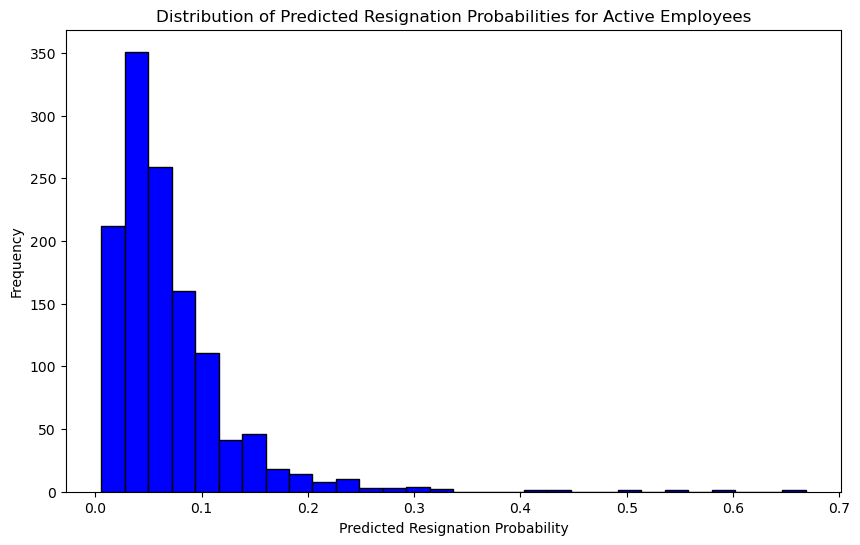

In [28]:
import matplotlib.pyplot as plt

# Plot the distribution of predicted resignation probabilities for active employees
plt.figure(figsize=(10, 6))
plt.hist(active_employees_df['Predicted Attrition Probability'], bins=30, color='blue', edgecolor='black')
plt.title('Distribution of Predicted Resignation Probabilities for Active Employees')
plt.xlabel('Predicted Resignation Probability')
plt.ylabel('Frequency')
plt.show()


In [29]:
# Set a threshold for high resignation risk
threshold = 0.5

# Classify employees with a probability greater than the threshold as "high risk"
active_employees_df['High Risk'] = active_employees_df['Predicted Attrition Probability'] > threshold

# Show the high-risk employees
high_risk_employees = active_employees_df[active_employees_df['High Risk'] == True]
print("\nHigh risk employees:")
print(high_risk_employees)



High risk employees:
      Actual Attrition  Predicted Attrition Probability  High Risk
2185                 0                         0.556907       True
2184                 0                         0.668373       True
5514                 0                         0.588147       True


In [30]:
# Assuming 'X_test' is the features for active employees
# 'y_pred_proba' contains predicted probabilities (from your Gradient Boosting model)

# Add the probabilities and high risk status to the DataFrame
import pandas as pd

# Example of high-risk threshold
high_risk_threshold = 0.5

# Add predicted probabilities to the DataFrame
all_employees_predictions = X_test.copy()  # Use the features DataFrame or create a new one

# Add predicted probabilities to the DataFrame
all_employees_predictions['Predicted Attrition Probability'] = y_pred_proba[:, 1]

# Add a high-risk column based on the threshold
all_employees_predictions['High Risk'] = all_employees_predictions['Predicted Attrition Probability'] >= high_risk_threshold

# Optionally, add Actual Attrition if it's available in your dataset
# all_employees_predictions['Actual Attrition'] = y_test

# Save to CSV
all_employees_predictions.to_csv('active_employees_with_resignation_probabilities.csv', index=False)


In [33]:
# Define a threshold for high risk (e.g., 0.5)
high_risk_threshold = 0.5

# Add a High Risk column: employees with a probability >= threshold are considered high risk
active_employees_df['High Risk'] = active_employees_df['Predicted Attrition Probability'] >= high_risk_threshold

# Include Employee ID from the 'employee' dataset
active_employees_df['Employee ID'] = employee.loc[employee['Employee ID'].isin(active_employees_df.index), 'Employee ID']

# Save to CSV
active_employees_df[['Employee ID', 'Predicted Attrition Probability', 'High Risk']].to_csv('active_employees_resignation_probabilities.csv', index=False)

# Display the saved file for review
print(active_employees_df.head())


      Actual Attrition  Predicted Attrition Probability  High Risk  \
101                  0                         0.100729      False   
2666                 0                         0.032608      False   
3838                 0                         0.071850      False   
2388                 0                         0.037668      False   
5438                 0                         0.141044      False   

      Employee ID  
101           NaN  
2666          NaN  
3838          NaN  
2388          NaN  
5438          NaN  


In [34]:
# Filter the employees where Current Employment Status is 'Active'
active_employees = employee[employee['Current Employment Status'] == 'Active']

# Merge the active employees with their predicted attrition probabilities
# Assuming `results_df` contains the predicted probabilities and is indexed by Employee ID
# Ensure Employee ID is a part of the results_df for merging
active_employees_with_probabilities = active_employees[['Employee ID']].merge(results_df, left_on='Employee ID', right_index=True, how='left')

# Save to CSV, including the Employee ID and predicted attrition probability
active_employees_with_probabilities.to_csv('active_employe_with_resignation_probabilities.csv', index=False)

# Display the top rows to confirm the results
print(active_employees_with_probabilities.head())


   Employee ID  Actual Attrition  Predicted Attrition Probability
0         1001               NaN                              NaN
1         1002               0.0                         0.072004
2         1003               NaN                              NaN
3         1004               NaN                              NaN
4         1005               0.0                         0.067098


In [35]:
# Ensure the 'Employee ID' is included in the results_df
results_df['Employee ID'] = y_test.index  # Assuming y_test index corresponds to Employee IDs

# Filter the employees where Current Employment Status is 'Active'
active_employees = employee[employee['Current Employment Status'] == 'Active']

# Merge the active employees with the predicted attrition probabilities
# Merge on 'Employee ID' to ensure we capture the predicted probabilities for each active employee
active_employees_with_probabilities = active_employees[['Employee ID']].merge(
    results_df[['Employee ID', 'Predicted Attrition Probability']], 
    on='Employee ID', 
    how='left'
)

# Save to CSV
active_employees_with_probabilities.to_csv('active_employees_with_resignation_probabilities.csv', index=False)

# Display the top rows to confirm the results
print(active_employees_with_probabilities.head())


   Employee ID  Predicted Attrition Probability
0         1001                              NaN
1         1002                         0.072004
2         1003                              NaN
3         1004                              NaN
4         1005                         0.067098


In [38]:
# Assuming you have a way to track the original indices of the test set
results_df = pd.DataFrame({
    'Employee ID': X_test.index,  # Use the original indices directly
    'Actual Attrition': y_test,
    'Predicted Attrition Probability': gb_model.predict_proba(X_test)[:, 1]
})

# Sort by Predicted Attrition Probability in descending order
results_df = results_df.sort_values('Predicted Attrition Probability', ascending=False)

# Save to CSV
results_df.to_csv('employee_resignation_probabilities.csv', index=False)

# Display the first few rows to verify
print(results_df.head())

      Employee ID  Actual Attrition  Predicted Attrition Probability
6300         6300                 1                         0.957176
6365         6365                 1                         0.846451
5931         5931                 1                         0.785732
4625         4625                 1                         0.783110
5048         5048                 1                         0.761982


In [39]:
# Filter active employees
active_employees = employee[employee['Current Employment Status'] == 'Active']

# Check the total number of active employees
total_active_employees = len(active_employees)

# Compare with the number of employees in your current dataset
print(f"Total Active Employees: {total_active_employees}")
print(f"Number of Employees in Current Dataset: {len(employee)}")

Total Active Employees: 1561
Number of Employees in Current Dataset: 1800


In [42]:
# Filter active employees
active_employees = employee[employee['Current Employment Status'] == 'Active']

# Predict probabilities for all active employees
active_employee_probas = gb_model.predict_proba(X_test)[:, 1]

# Create a DataFrame with Employee ID and Predicted Attrition Probability
results_df = pd.DataFrame({
    'Employee ID': active_employees['Employee ID'][:len(active_employee_probas)],
    'Predicted Attrition Probability': active_employee_probas
})

# Sort by Predicted Attrition Probability in descending order
results_df = results_df.sort_values('Predicted Attrition Probability', ascending=False)

# Save to CSV
results_df.to_csv('1active_employee_resignation_probabilities.csv', index=False)

# Display the first few rows to verify
print(results_df.head())

      Employee ID  Predicted Attrition Probability
1085         2086                         0.957176
1087         2088                         0.846451
170          1171                         0.785732
1155         2156                         0.783110
1323         2324                         0.761982


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# First load the data
def load_data():
    try:
        employee = pd.read_csv('employee.csv')
        resigned_table = pd.read_csv('resigned_table.csv')
        resignation_reason = pd.read_csv('resignation_reason.csv')
        exit_interview_survey = pd.read_csv('exit_interview_survey.csv')
        employee_feedback_survey = pd.read_csv('employee_feedback_survey.csv')
        
        return employee, resigned_table, resignation_reason, exit_interview_survey, employee_feedback_survey
    except FileNotFoundError as e:
        print(f"Error loading files: {e}")
        return None

def prepare_data(employee, resigned_table, resignation_reason, exit_interview_survey, employee_feedback_survey):
    # Merge resigned_table with resignation_reason
    resigned_data = pd.merge(
        resigned_table,
        resignation_reason,
        on='Resignation Reason ID',
        how='left'
    )
    
    # Merge with employee data
    full_data = pd.merge(
        employee,
        resigned_data,
        on='Employee ID',
        how='left'
    )
    
    # Merge with exit interview data
    full_data = pd.merge(
        full_data,
        exit_interview_survey,
        on='Employee ID',
        how='left'
    )
    
    # Get the most recent feedback for each employee
    latest_feedback = employee_feedback_survey.sort_values('Year').groupby('Employee ID').last().reset_index()
    
    # Merge with employee feedback
    full_data = pd.merge(
        full_data,
        latest_feedback,
        on='Employee ID',
        how='left'
    )
    
    return full_data

def add_resignation_indicator(df):
    df['Has_Resigned'] = df['Resigned Date'].notna().astype(int)
    return df

def calculate_correlations(df):
    # Select numerical columns and 'Has_Resigned'
    correlation_cols = [
        'Base Salary ($)',
        'Times Promoted',
        'Years at Company',
        'Work Environment Satisfaction Score',
        'Team Collaboration Score',
        'Career Growth Satisfaction',
        'Overall Performance Rating',
        'Has_Resigned'
    ]
    
    # Calculate correlations
    correlations = df[correlation_cols].corr()['Has_Resigned'].sort_values()
    
    return correlations

def plot_correlations(correlations):
    plt.figure(figsize=(12, 8))
    sns.barplot(x=correlations.values[:-1], y=correlations.index[:-1])
    plt.title('Factors Correlated with Employee Resignation')
    plt.xlabel('Correlation Coefficient')
    plt.tight_layout()
    plt.show()

def analyze_specific_factors(df):
    # Analyze salary impact
    salary_bins = pd.qcut(df['Base Salary ($)'], q=5)
    salary_analysis = df.groupby(salary_bins)['Has_Resigned'].agg(['mean', 'count'])
    
    # Analyze tenure impact
    tenure_bins = pd.qcut(df['Years at Company'], q=5)
    tenure_analysis = df.groupby(tenure_bins)['Has_Resigned'].agg(['mean', 'count'])
    
    print("\nResignation Rate by Salary Quintiles:")
    print(salary_analysis)
    
    print("\nResignation Rate by Tenure Quintiles:")
    print(tenure_analysis)

def create_detailed_visualizations(df):
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    
    # Salary vs Resignation
    sns.boxplot(x='Has_Resigned', y='Base Salary ($)', data=df, ax=axes[0,0])
    axes[0,0].set_title('Salary Distribution by Resignation Status')
    
    # Years at Company vs Resignation
    sns.boxplot(x='Has_Resigned', y='Years at Company', data=df, ax=axes[0,1])
    axes[0,1].set_title('Tenure Distribution by Resignation Status')
    
    # Department vs Resignation
    dept_resign = df.groupby('Department')['Has_Resigned'].mean().sort_values()
    dept_resign.plot(kind='bar', ax=axes[1,0])
    axes[1,0].set_title('Resignation Rate by Department')
    
    # Performance Rating vs Resignation
    perf_resign = df.groupby('Overall Performance Rating')['Has_Resigned'].mean().sort_values()
    perf_resign.plot(kind='bar', ax=axes[1,1])
    axes[1,1].set_title('Resignation Rate by Performance Rating')
    
    plt.tight_layout()
    plt.show()

def analyze_resignations(employee, resigned_table, resignation_reason, exit_interview_survey, employee_feedback_survey):
    # Prepare data
    full_data = prepare_data(employee, resigned_table, resignation_reason, 
                           exit_interview_survey, employee_feedback_survey)
    
    # Add resignation indicator
    full_data = add_resignation_indicator(full_data)
    
    # Calculate correlations
    correlations = calculate_correlations(full_data)
    
    # Plot correlations
    plot_correlations(correlations)
    
    # Print correlations
    print("\nCorrelations with Resignation:")
    print(correlations)
    
    # Analyze categorical variables
    categorical_analysis = pd.DataFrame({
        'Resignation_Rate': full_data.groupby('Department')['Has_Resigned'].mean(),
        'Count': full_data.groupby('Department')['Has_Resigned'].count()
    }).sort_values('Resignation_Rate', ascending=False)
    
    print("\nResignation Rates by Department:")
    print(categorical_analysis)
    
    # Additional analyses
    analyze_specific_factors(full_data)
    create_detailed_visualizations(full_data)

# Main execution
if __name__ == "__main__":
    # Load the data first
    data = load_data()
    
    if data is not None:
        employee, resigned_table, resignation_reason, exit_interview_survey, employee_feedback_survey = data
        
        # Run the analysis
        analyze_resignations(employee, resigned_table, resignation_reason, 
                           exit_interview_survey, employee_feedback_survey)


ValueError: could not convert string to float: 'No'